In [0]:
# Migration du premier fichier depuis /bronze vers /gold 
from azure.storage.blob import BlobServiceClient
import pandas as pd
from io import StringIO
import json
import os

storage_account_name =  os.getenv("STORAGE_ACCOUNT")
container_name = os.getenv("CONTAINER_NAME")
storage_account_key = os.getenv("KEY")

# connexion avec Azure Blob Storage
blob_service_client = BlobServiceClient(
    account_url=f"https://{storage_account_name}.blob.core.windows.net",
    credential=storage_account_key
)

blob_client = blob_service_client.get_blob_client(container=container_name, blob="bronze/data-complete-block/2025_01_06_1736127774473_0.csv")

blob_data = blob_client.download_blob()
file_content = blob_data.readall().decode("utf-8")

df = pd.read_csv(StringIO(file_content), header=None)

# supprimer les deux premières colonnes suite à l'ingestion avec Airbyte
df = df.drop(columns=[0, 1])

# pour transformer la troisième colonne (JSON) en dico
def parse_json(json_str):
    try:
        return json.loads(json_str)  # Convertir la chaîne JSON
    except json.JSONDecodeError:
        return {}

df[2] = df[2].apply(parse_json)

df_json = pd.json_normalize(df[2])

df_final = pd.concat([df.drop(columns=[2]), df_json], axis=1)

# Nettoyage : supprimer les colonnes inutiles si elles existent
columns_to_remove = [
    'abilities', 'japanese_name', 'classfication', 'capture_rate', 
    'base_egg_steps', 'base_happiness', 'experience_growth', 'base_total', 
    'generation', 'height_m', 'weight_kg', 'pokedex_number', 
    'is_legendary', 'percentage_male'
]

# Supprimer les colonnes spécifiées si elles existent dans le DataFrame
df_final_cleaned = df_final.drop(columns=[col for col in columns_to_remove if col in df_final.columns])

# Sélectionner les colonnes pertinentes pour le résultat final
df_final_relevant = df_final_cleaned[[
    'name', 'type1', 'type2', 'attack', 'defense', 'sp_attack', 'sp_defense', 'speed', 
    'against_bug', 'against_dark', 'against_ghost', 'against_grass', 'against_ground',
    'against_ice', 'against_normal', 'against_poison', 'against_psychic', 'against_rock', 
    'against_steel', 'against_water'
]]

df_final_relevant_cleaned = df_final_relevant.dropna()

# Sauvegarder le fichier nettoyé dans le répertoire gold
output_blob_client = blob_service_client.get_blob_client(container=container_name, blob="gold/2025_01_06_1736127774473_0.csv")

# Convertir le DataFrame en CSV et télécharger le fichier sur Azure Blob Storage
output_blob_client.upload_blob(df_final_relevant_cleaned.to_csv(index=False), overwrite=True)

print("Fichier nettoyé enregistré dans le répertoire 'gold'.")

Fichier nettoyé enregistré dans le répertoire 'gold'.


In [0]:
# Migration du second fichier depuis /bronze vers /gold
from azure.storage.blob import BlobServiceClient
import pandas as pd
from io import StringIO
import json
import os

storage_account_name =  os.getenv("STORAGE_ACCOUNT")
container_name = os.getenv("CONTAINER_NAME")
storage_account_key = os.getenv("KEY")

# Créer une connexion avec Azure Blob Storage
blob_service_client = BlobServiceClient(
    account_url=f"https://{storage_account_name}.blob.core.windows.net",
    credential=storage_account_key
)

blob_client = blob_service_client.get_blob_client(container=container_name, blob="bronze/data-database-block/2025_01_06_1736128104803_0.csv")

blob_data = blob_client.download_blob()
file_content = blob_data.readall().decode("utf-8")

df = pd.read_csv(StringIO(file_content), header=None)

df = df.drop(columns=[0, 1])

def parse_json(json_str):
    try:
        return json.loads(json_str) 
    except json.JSONDecodeError:
        return {}

df[2] = df[2].apply(parse_json)

df_json = pd.json_normalize(df[2])

df_final = pd.concat([df.drop(columns=[2]), df_json], axis=1)

columns_to_keep = [
    'Pokemon Name', 'Primary Type', 'Secondary Type', 'Attack Stat', 'Defense Stat', 
    'Special Attack Stat', 'Special Defense Stat', 'Speed Stat', 'Catch Rate', 
    'Health Stat', 'Base Happiness', 'Pokemon Weight', 'Pokemon Height', 
    'Base Stat Total', 'Legendary Type', 'Classification', 'Primary Ability'
]

# Supprimer les colonnes qui ne sont pas dans le DataFrame, si elles existent
df_final_relevant = df_final[[col for col in columns_to_keep if col in df_final.columns]]

# Supprimer les lignes contenant des NaN
df_final_relevant_cleaned = df_final_relevant.dropna()

output_blob_client = blob_service_client.get_blob_client(container=container_name, blob="gold/2025_01_06_1736128104803_0.csv")
output_blob_client.upload_blob(df_final_relevant_cleaned.to_csv(index=False), overwrite=True)

print("Fichier nettoyé enregistré dans le répertoire 'gold'.")


Fichier nettoyé enregistré dans le répertoire 'gold'.


In [0]:
# Analyse des données dans /gold
from azure.storage.blob import BlobServiceClient
import pandas as pd
from io import StringIO
import os
storage_account_name =  os.getenv("STORAGE_ACCOUNT")
container_name = os.getenv("CONTAINER_NAME")
storage_account_key = os.getenv("KEY")

# Créer une connexion avec Azure Blob Storage
blob_service_client = BlobServiceClient(
    account_url=f"https://{storage_account_name}.blob.core.windows.net",
    credential=storage_account_key
)

# Fonction pour charger un fichier depuis Azure Blob Storage
def load_blob_to_dataframe(blob_path):
    # Accéder au fichier dans le répertoire gold
    blob_client = blob_service_client.get_blob_client(container=container_name, blob=blob_path)

    # Télécharger le contenu du blob
    blob_data = blob_client.download_blob()
    file_content = blob_data.readall().decode("utf-8")

    # Charger le contenu dans un DataFrame Pandas
    df = pd.read_csv(StringIO(file_content))

    return df

# Charger les deux fichiers nettoyés dans le répertoire 'gold'
file_1_path = "gold/2025_01_06_1736127774473_0.csv"
file_2_path = "gold/2025_01_06_1736128104803_0.csv"

df_file_1 = load_blob_to_dataframe(file_1_path)
df_file_2 = load_blob_to_dataframe(file_2_path)

# Afficher les premières lignes des fichiers pour vérifier
print("Contenu du premier fichier :")
print(df_file_1.head())

print("\nContenu du deuxième fichier :")
print(df_file_2.head())

# Calcul des statistiques descriptives pour le premier fichier
print("\nStatistiques descriptives pour le premier fichier :")
print(df_file_1.describe())

# Calcul des statistiques descriptives pour le deuxième fichier
print("\nStatistiques descriptives pour le deuxième fichier :")
print(df_file_2.describe())

# Corrélations pour les variables numériques dans le premier fichier
print("\nCorrélations pour le premier fichier :")
print(df_file_1.corr())

# Corrélations pour les variables numériques dans le deuxième fichier
print("\nCorrélations pour le deuxième fichier :")
print(df_file_2.corr())



Contenu du premier fichier :
         name  type1   type2  attack  defense  sp_attack  sp_defense  speed  \
0   Bulbasaur  grass  poison    49.0     49.0       65.0        65.0   45.0   
1     Ivysaur  grass  poison    62.0     63.0       80.0        80.0   60.0   
2    Venusaur  grass  poison   100.0    123.0      122.0       120.0   80.0   
3   Charizard   fire  flying   104.0     78.0      159.0       115.0  100.0   
4  Butterfree    bug  flying    45.0     50.0       90.0        80.0   70.0   

   against_bug  against_dark  against_ghost  against_grass  against_ground  \
0         1.00           1.0            1.0           0.25             1.0   
1         1.00           1.0            1.0           0.25             1.0   
2         1.00           1.0            1.0           0.25             1.0   
3         0.25           1.0            1.0           0.25             0.0   
4         0.50           1.0            1.0           0.25             0.0   

   against_ice  against_nor


Statistiques descriptives pour le premier fichier :
           attack     defense   sp_attack  sp_defense       speed  \
count  417.000000  417.000000  417.000000  417.000000  417.000000   
mean    81.196643   77.661871   74.520384   73.467626   68.848921   
std     33.098261   32.785775   33.251015   27.966920   28.901585   
min     10.000000   15.000000   10.000000   20.000000    5.000000   
25%     55.000000   52.000000   50.000000   52.000000   45.000000   
50%     78.000000   74.000000   70.000000   70.000000   67.000000   
75%    100.000000   95.000000   95.000000   90.000000   90.000000   
max    185.000000  230.000000  180.000000  230.000000  160.000000   

       against_bug  against_dark  against_ghost  against_grass  \
count   417.000000    417.000000     417.000000     417.000000   
mean      0.908873      1.060552       1.022782       1.002998   
std       0.653967      0.487607       0.584317       0.966766   
min       0.250000      0.250000       0.000000       0.25000

<command-1383710340809427>:53: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  average_advantages = type_advantages.mean().sort_values()


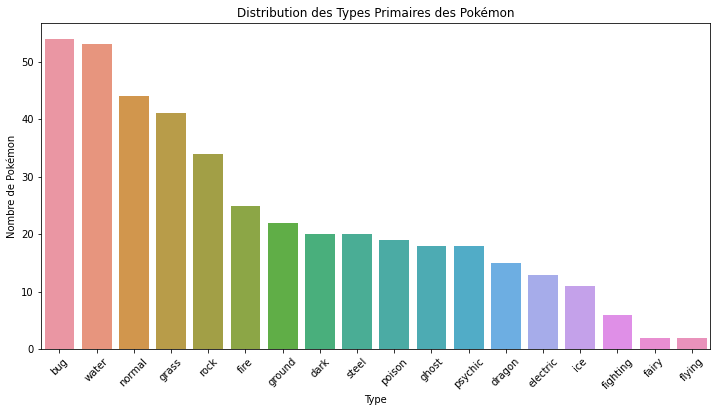

In [0]:
# Analyse des données dans /gold v2
from azure.storage.blob import BlobServiceClient
import pandas as pd
from io import StringIO
import os

storage_account_name = os.getenv("STORAGE_ACCOUNT")
container_name = os.getenv("CONTAINER_NAME")
storage_account_key = os.getenv("KEY")

blob_service_client = BlobServiceClient(
    account_url=f"https://{storage_account_name}.blob.core.windows.net",
    credential=storage_account_key
)

# Fonction pour load un fichier depuis Azure Blob Storage
def load_blob_to_dataframe(blob_path):
    # Accéder au fichier dans le répertoire gold
    blob_client = blob_service_client.get_blob_client(container=container_name, blob=blob_path)
    blob_data = blob_client.download_blob()
    file_content = blob_data.readall().decode("utf-8")
    df = pd.read_csv(StringIO(file_content))

    return df

# Charger les deux fichiers du répertoire 'gold'
file_1_path = "gold/2025_01_06_1736127774473_0.csv"
file_2_path = "gold/2025_01_06_1736128104803_0.csv"

df_file_1 = load_blob_to_dataframe(file_1_path)
df_file_2 = load_blob_to_dataframe(file_2_path)

# print(df_file_1.head())
# print(df_file_2.head())

# Analyse simple : Calculer des statistiques descriptives pour le premier fichier
print("\nStatistiques descriptives pour le premier fichier :")
print(df_file_1.describe())

# Analyse simple : Calculer des statistiques descriptives pour le deuxième fichier
print("\nStatistiques descriptives pour le deuxième fichier :")
print(df_file_2.describe())

# Analyse des interactions en combat (Types et Avantages/Désavantages)
print("\nAnalyse des interactions en combat pour le premier fichier :")
type_advantages = df_file_1[
    ['type1', 'type2', 'against_bug', 'against_dark', 'against_ghost', 
     'against_grass', 'against_ground', 'against_ice', 'against_normal', 
     'against_poison', 'against_psychic', 'against_rock', 'against_steel', 'against_water']
]

# Calculer la moyenne des "avantages" contre chaque type
average_advantages = type_advantages.mean().sort_values()
print("\nMoyenne des avantages par type (faiblesse ou résistance moyenne) :")
print(average_advantages)

# Identifier les types les + ou - résistants
strong_against = average_advantages[average_advantages > 1].index.tolist()
weak_against = average_advantages[average_advantages < 1].index.tolist()

print("\nTypes les plus résistants (moyenne > 1) :")
print(strong_against)

print("\nTypes les plus faibles (moyenne < 1) :")
print(weak_against)

# analyse des statistiques combinées des fichiers
print("\nAnalyse combinée des statistiques de combat :")

# Merge sur les noms des Pokémon pour avoir une vue complète
df_combined = pd.merge(
    df_file_1.rename(columns={'name': 'Pokemon Name'}),
    df_file_2,
    on='Pokemon Name',
    how='inner'
)

# premières lignes des données combinées
print("\nDonnées combinées :")
print(df_combined.head())

# Corrélation des stats offensives/défensives
correlations = df_combined[['Attack Stat', 'Defense Stat', 'Special Attack Stat', 'Special Defense Stat', 'Speed Stat']].corr()
print("\nCorrélations entre les statistiques offensives et défensives :")
print(correlations)

# Visu des forces et faiblesses par type
import seaborn as sns
import matplotlib.pyplot as plt

# distribution des types de Pokémon
plt.figure(figsize=(12, 6))
sns.countplot(data=df_file_1, x='type1', order=df_file_1['type1'].value_counts().index)
plt.title('Distribution des Types Primaires des Pokémon')
plt.xlabel('Type')
plt.ylabel('Nombre de Pokémon')
plt.xticks(rotation=45)
plt.show()
